In [1]:
import numpy as np
import pandas as pd

X_train = np.load('../data/processed/train.npz')['x']
y_train = np.load('../data/processed/train.npz')['y']
X_v = np.load('../data/processed/v.npz')['x']
y_v = np.load('../data/processed/v.npz')['y']

In [2]:
uncertainty = pd.read_csv('../outputs/results/aleatoric.csv')['0']
confidence = pd.read_csv('../outputs/results/confidence.csv')['0']

uncertainty_thresh = 0.2
thresh = 0.25
conf_thresh_low = thresh
conf_thresh_high = 1 - thresh
conf_thresh = 0.5

hard_scores = confidence[(confidence <= conf_thresh_low) & (uncertainty <= uncertainty_thresh)]
easy_scores = confidence[(confidence >= conf_thresh_high) & (uncertainty <= uncertainty_thresh)]
ambig_scores = uncertainty[((confidence > conf_thresh_low) & (confidence < conf_thresh_high)) | (uncertainty > uncertainty_thresh)]

# Now hardest first, then most ambiguous, then easy
ind_hard = pd.Series(hard_scores).sort_values(ascending=True).index 
ind_easy = pd.Series(easy_scores).sort_values(ascending=True).index
ind_ambig = pd.Series(ambig_scores).sort_values(ascending=False).index
ind_dataiq = list(np.concatenate((ind_hard, ind_ambig, ind_easy)))

In [3]:
from scipy.stats import spearmanr

knn_1 = pd.read_csv('../outputs/results/knn_1.csv')['0']
knn_5 = pd.read_csv('../outputs/results/knn_5.csv')['0']
knn_100 = pd.read_csv('../outputs/results/knn_100.csv')['0']

ind_knn_1 = list(knn_1.sort_values(ascending=True).index)
ind_knn_5 = list(knn_5.sort_values(ascending=True).index)
ind_knn_100 = list(knn_100.sort_values(ascending=True).index)

print(spearmanr(ind_knn_1, ind_knn_5))
print(spearmanr(ind_knn_1, ind_knn_100))
print(spearmanr(ind_knn_5, ind_knn_100)) # very inconsistent! cannot reject at 5% level!

SignificanceResult(statistic=0.000692761456731243, pvalue=0.678121788235852)
SignificanceResult(statistic=-0.0028343159235476633, pvalue=0.08950442277313683)
SignificanceResult(statistic=0.0024680964167793787, pvalue=0.13924255202222013)


In [4]:
print(spearmanr(ind_knn_5, ind_dataiq))

SignificanceResult(statistic=0.0010943854032181531, pvalue=0.5120576650661224)


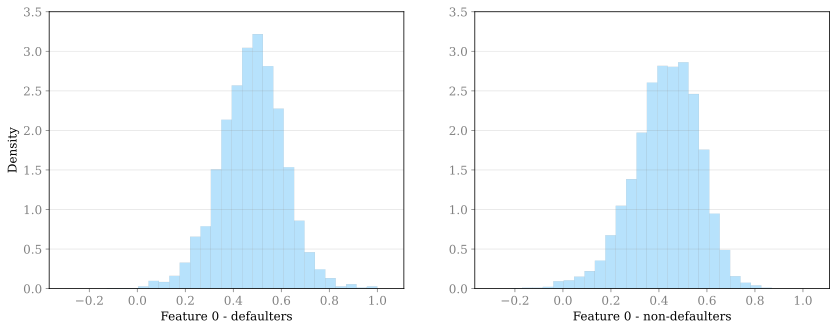

In [25]:
ind_interest = [ix for ix in ind_ambig if knn_5[ix] < -0.000005]

X_interest = X_train[ind_interest]
y_interest = y_train[ind_interest]
interest_def = X_interest[y_interest == 1, :]
interest_nondef = X_interest[y_interest == 0, :]

%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('axes', grid=True)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)
plt.rc('ytick', direction='out', color='gray')
plt.rc('xtick', direction='out', color='gray')
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Feature 0
min_v, max_v = -0.3, 1
bin_width = (max_v - min_v) / 30
bin_edges = np.arange(min_v, max_v + bin_width, bin_width)
axes[0].hist(interest_def[:, 0], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.6, density=True)
axes[0].set_xlabel('Feature 0 - defaulters')
axes[0].set_ylabel('Density')
axes[0].grid(axis='x')
axes[0].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])

axes[1].hist(interest_nondef[:, 0], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.6, density=True)
axes[1].set_xlabel('Feature 0 - non-defaulters')
axes[1].grid(axis='x')
axes[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]);